Code to simulate the effect of multiemitters when imaging a ring structure.

In [1]:
%pylab inline
from scipy import stats

import warnings

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Simulates and analyse multi-emitters in a ring structure
# Calculates a ratio between the number of blinking events on the peripheral vs center of the ring

In [3]:
def generate_points_in_ring(radius, num_pts):
    """
    Calculate the position of points on a ring in Cartesian coordinates.
    
    Parameters
    ----------
    radius : float
        ring radius
    num_pts : int
        numter of points on the ring
    """
    pt_polar_theta = np.linspace(0, 2*np.pi, num_pts, False)
    pt_cart = radius * np.exp(1j * pt_polar_theta)

    return np.stack([pt_cart.real, pt_cart.imag], 1)

def calculate_prob(num_pts, p):
    """
    Calculate binomal model-based blinking prob.
    
    Parameters
    ----------
    num_pts : int
        number of targets / docking strands
    p : float
        duty cycle
    """
    p_x_0 = stats.binom.pmf(0, num_pts, p)
    p_x_1 = stats.binom.pmf(1, num_pts, p)
    p_multiemitter = 1 - p_x_1 / (1 - p_x_0)
    
    prob = dict()
    prob['dutycycle'] = p
    prob['p_single'] = p_x_1
    prob['p_multiemitter'] = p_multiemitter
    
    return prob

def generate_localizations(targets, duration, p, error):
    """
    Simulate localization data.
    
    Parameters
    ----------
    targets : array_like
        coordinates of targets / docking strands
    duration : int
        duration to simulate
    p : float
        duty cycle
    error : float
        localization error
    """
    
    # Simulate blink on/off state
    num_pts = targets.shape[0]
    blink_state = np.random.uniform(0, 1, size=(num_pts, duration)) < p
    
    # Measure observed statistics
    observed_p = 1. * blink_state.sum() / blink_state.size
    blink_state_observed = np.sum(blink_state, axis=0)
    observed_x_0 = 1. * (blink_state_observed==1).sum() / len(blink_state_observed)
    try:
        observed_p_multiemitter = 1. * (blink_state_observed>1).sum() / (blink_state_observed>0).sum()
    except ZeroDivisionError as e:
        print(e)
        observed_p_multiemitter = np.nan

    prob = dict()
    prob['dutycycle'] = observed_p
    prob['p_single'] = observed_x_0
    prob['p_multiemitter'] = observed_p_multiemitter
    
    # Simulate positions
    blink_position = np.zeros((num_pts, duration, 2))    
    blink_position[blink_state] =  np.random.normal(scale=error, size=(blink_state.sum(), 2))
    blink_position = blink_position + targets[:, None, :]   
    blink_position[~blink_state] = np.nan
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', message='Mean of empty slice')
        blink_observed_position = np.nanmean(blink_position, axis=0)
    return blink_observed_position[np.any(~np.isnan(blink_observed_position), axis=1)], prob

In [4]:
def calculate_ratio(radial_dis, ratio_lower, ratio_upper):
    """
    Calculates ratio between ring peripheral and center.
    
    Parameters
    ----------
    radial_dis : array_like
        array of radial distances
    ratio_upper : array_like
        bounds for ring center
    ratio_upper : array_like
        bounds for ring peripheral
    """
    lower_band = np.logical_and(radial_dis >= ratio_lower[0], radial_dis <= ratio_lower[1])
    upper_band = np.logical_and(radial_dis >= ratio_upper[0], radial_dis <= ratio_upper[1])
    return 1.0 * upper_band.sum() / lower_band.sum()    

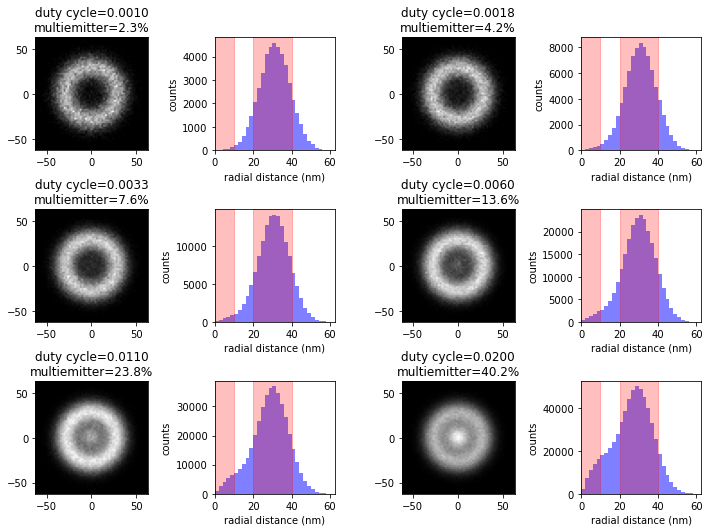

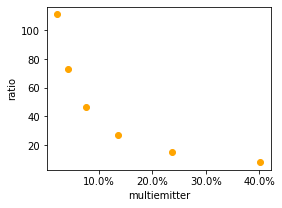

In [5]:
def simulate_rings(ring_radius=30.0, ring_num_pts=48, duration=1000000, p_range=np.logspace(-3,-2,10),
                   loc_error=10.0, ratio_lower=[0, 10], ratio_upper=[20,40]):
    
    """
    Simulates and analyse blinking on a ring structure.
    
    Parameters
    ----------
    ring_radius  : float
        ring radius
    ring_num_pts : int
        number of targets / docking strands on the ring
    duration : int
        duration to simulate
    p_range : array_like
        list of duty cycles to simulate
    loc_err : float
        localization error
    ratio_lower : array_like
        range of radial distances for center region
    ratio_upper : array_like
        range of radial distances for peripheral region
    """
    
    fig, axes = subplots(np.ceil(len(p_range)*0.5).astype(int), 4, figsize = (4*2.5, 0.5*2.5*len(p_range)))
    axes = axes.flat
    
    # Setup
    results = np.zeros(len(p_range), dtype=[("p", np.float), ("multiemitter", np.float),
                                            ("ratio", np.float)])
    results_hist2d = list()
    results_radial_distance = list()
    
    pt_positions = generate_points_in_ring(ring_radius, ring_num_pts)
    limits = ring_radius + 4 * loc_error
    bins = np.arange(-limits, limits+2., 2)
    
    # Simulate blinks and calculate radial distances for each duty cycle
    for i, p in enumerate(p_range):
        model_probs = calculate_prob(ring_num_pts, p)
        results['p'][i] = model_probs['dutycycle']
        results['multiemitter'][i] = model_probs['p_multiemitter']
        
        pt_locs, observed_probs = generate_localizations(pt_positions, duration, p, loc_error)
        
        radial_dis = np.linalg.norm(pt_locs, axis=1)#     
        radial_counts, radial_edges = np.histogram(radial_dis, bins=np.arange(0, limits+2., 2))
        radial_centers = 0.5 * (radial_edges[1:] + radial_edges[:-1])
        results_radial_distance.append((radial_centers, radial_counts))        
        results['ratio'][i] = calculate_ratio(radial_dis, ratio_lower, ratio_upper)
        
        # Generate a 2D histogram render of the localization data.
        # Just for a visual check, not used for further calculations.
        counts, xedges, yedges = np.histogram2d(pt_locs[:, 0], pt_locs[:, 1], bins=bins)
        results_hist2d.append(counts)

    # Plot data
    for i, p in enumerate(p_range):
        # 2D histogram render
        axes[2*i].imshow(results_hist2d[i], extent=(bins[0], bins[-1], bins[0], bins[-1]), cmap='gray')
        axes[2*i].set_aspect(1)
        axes[2*i].set_title("duty cycle={:.4f}\nmultiemitter={:.1%}".format(results['p'][i],
                                                                             results['multiemitter'][i]))
        
        # Histogram of radial distances
        axes[2*i+1].bar(results_radial_distance[i][0], results_radial_distance[i][1],                       
                       np.diff(results_radial_distance[i][0][:2])[0], alpha=0.5, color='blue')
        axes[2*i+1].axvspan(ratio_lower[0], ratio_lower[1], color='red', alpha=0.25)
        axes[2*i+1].axvspan(ratio_upper[0], ratio_upper[1], color='red', alpha=0.25)
        axes[2*i+1].set_xlabel('radial distance (nm)')
        axes[2*i+1].set_ylabel('counts')
        axes[2*i+1].set_xlim(0, limits)
        
    fig.tight_layout()
    
    # Calibration curve
    fig, ax = subplots(1, 1, figsize=(4,3))

    ax.scatter(results['multiemitter'], results['ratio'], c='orange')
    ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
    ax.set_xlabel('multiemitter')
    ax.set_ylabel('ratio')

ratio_lower=[0,10]
ratio_upper=[20,40]
p_range = np.logspace(-3,np.log10(0.02),6)
ring_num_pts = 48
results = simulate_rings(30.23, ring_num_pts=ring_num_pts, duration=1000000, p_range=p_range,
                         loc_error=8.09, ratio_lower=ratio_lower, ratio_upper=ratio_upper)